# v4.1  of ParamGen notebook
## v2.0
Adjustment in typical_range & full_range based on preliminary NSE analysis
Adjustment in stratified_sampling_for_dependent_param(args)->constrained_sample(args): logics to add more randomness
Setting of constrained_sample(args): constraint multipliers are adjusted to cover parameter space a bit better
Targetting 1,000 ~ 5,000 parameter-sets
## v3.0
1. Sobol version, as LHS is slacking.
## v4.0 & v4.1
Dependent parameter high value problem

In [17]:
import numpy as np
from scipy.stats import norm
import os

#from pyDOE import lhs

In [2]:
parameter_names = ['beta_W', 'beta_HP', 'D_H', 'D_P', 'Kf_fast', 'Kf_slow', 'Sumax_W', 'Sumax_HP']

typical_range = {
    'beta_W': {'min': 0.1, 'max': 2},
    'beta_HP': {'min': 0.1, 'max': 2}, # Placeholder values
    'D_H': {'min': 0.1, 'max': 0.3},
    'D_P': {'min': 0.1, 'max': 0.6}, # Placeholder values
    'Kf_fast': {'min': 0.04, 'max': 0.06},
    'Kf_slow': {'min': 0.005, 'max': 0.01},
    'Sumax_W': {'min': 70, 'max': 150},
    'Sumax_HP': {'min': 100, 'max': 350}, # Placeholder values
}

# Parameter range constraints
# Gharari et al. (2014) = basic range
# Gao et al. (2014) = very large range
# Euser et al. (2015) = most realisitc range
full_range = {
    'beta_W': {'min': 0.1, 'max': 5},
    'beta_HP': {'min': 0.1, 'max': 5},
    'D_H': {'min': 0.1, 'max': 0.6},
    'D_P': {'min': 0.1, 'max': 1},
    'Kf_fast': {'min': 0.04, 'max': 0.16}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'Kf_slow': {'min': 0.003, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_HP': {'min': 50, 'max': 1000},
}

# Sobol

In [3]:
import numpy as np
from scipy.stats import qmc

def joint_sobol_sampling(param_ranges, num_samples, decimals=3):
    """Generates Sobol samples for multiple parameters jointly."""
    num_params = len(param_ranges)
    sampler = qmc.Sobol(d=num_params, scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = {}

    # Initialize samples dictionary with arrays
    for param in param_ranges:
        samples[param] = np.zeros(num_samples)

    # Generate independent parameter samples first
    independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    for i, param in enumerate(independent_params):
        bounds = param_ranges[param]
        scaled_samples = sobol_samples[:, i] * (bounds['max'] - bounds['min']) + bounds['min']
        samples[param] = np.round(scaled_samples, decimals)

    # Now generate dependent parameter samples using the already sampled independent parameters
    dependent_params_indices = {
        'beta_HP': len(independent_params),
        'D_P': len(independent_params) + 1,
        'Sumax_HP': len(independent_params) + 2
    }
    
    for param, bounds in param_ranges.items():
        if param in dependent_params_indices:
            dep_index = dependent_params_indices[param]
            if param == 'beta_HP':
                min_vals = np.maximum(samples['beta_W'], bounds['min'])
                max_vals = np.minimum(samples['beta_W'] * 1.1, bounds['max'])
            elif param == 'D_P':
                min_vals = np.maximum(samples['D_H'], bounds['min'])
                max_vals = np.minimum(samples['D_H'] * 1.5, bounds['max'])
            elif param == 'Sumax_HP':
                min_vals = np.maximum(samples['Sumax_W'], bounds['min'])
                max_vals = np.minimum(samples['Sumax_W'] * 2.5, bounds['max'])
            
            # Scale the Sobol samples within the updated bounds
            scaled_samples = sobol_samples[:, dep_index] * (max_vals - min_vals) + min_vals
            samples[param] = np.round(scaled_samples, decimals)

    return samples

# Beta constraining
Model performance declines noticeably when beta value exceeds 4.5

In [4]:
###Last charm>?
import numpy as np
import copy

def generate_samples_with_constraints(param_ranges_in, num_samples, threshold, max_percentage, decimals):
    """Generates samples ensuring the constraints on exceedance percentage."""
    param_ranges = copy.deepcopy(param_ranges_in)
    exceedance_limit = int(num_samples * max_percentage / 100)
    samples_accumulated = {param: [] for param in param_ranges}
    total_collected = 0
    total_exceeding = 0

    initial_max_beta_W = param_ranges['beta_W']['max']
    initial_max_beta_HP = param_ranges['beta_HP']['max']

    while total_collected < num_samples:
        remaining_samples = num_samples - total_collected
        samples = joint_sobol_sampling(param_ranges, remaining_samples, decimals)

        num_generated_samples = len(samples['beta_W'])

        # Calculate the number of exceedances for beta_W and beta_HP
        beta_W_exceeding = np.sum(np.array(samples['beta_W']) > threshold)
        beta_HP_exceeding = np.sum(np.array(samples['beta_HP']) > threshold)
        combined_exceeding = beta_W_exceeding + beta_HP_exceeding

        if total_exceeding + combined_exceeding <= exceedance_limit:
            # Collect all samples
            for param in param_ranges:
                samples_accumulated[param].extend(samples[param])
            total_collected += num_generated_samples
            total_exceeding += combined_exceeding
        else:
            # Selectively accept samples to keep exceedance under limit
            for i in range(num_generated_samples):
                if total_exceeding < exceedance_limit:
                    if (samples['beta_W'][i] > threshold or samples['beta_HP'][i] > threshold):
                        if (samples['beta_W'][i] > threshold and samples['beta_HP'][i] > threshold):
                            # If both exceed, count twice
                            if total_exceeding + 2 <= exceedance_limit:
                                for param in param_ranges:
                                    samples_accumulated[param].append(samples[param][i])
                                total_collected += 1
                                total_exceeding += 2
                        else:
                            # If only one exceeds
                            for param in param_ranges:
                                samples_accumulated[param].append(samples[param][i])
                            total_collected += 1
                            total_exceeding += 1
                    else:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1
                else:
                    if samples['beta_W'][i] <= threshold and samples['beta_HP'][i] <= threshold:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1

            # Gradually narrow parameter ranges dynamically
            if beta_W_exceeding + len(samples_accumulated['beta_W']) > exceedance_limit:
                current_max_beta_W = param_ranges['beta_W']['max']
                param_ranges['beta_W']['max'] = max(threshold, current_max_beta_W - 0.1 * (current_max_beta_W - threshold))
            if beta_HP_exceeding + len(samples_accumulated['beta_HP']) > exceedance_limit:
                current_max_beta_HP = param_ranges['beta_HP']['max']
                param_ranges['beta_HP']['max'] = max(threshold, current_max_beta_HP - 0.1 * (current_max_beta_HP - threshold))

    # Ensure all lists are exactly num_samples in length
    for param in samples_accumulated:
        samples_accumulated[param] = np.array(samples_accumulated[param][:num_samples])

    return samples_accumulated


## Wrapper for easy use

In [5]:
def generate_custom_samples(param_ranges, num_samples, decimals=4):
    """Generates samples considering direct relationships between parameters."""
    independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    independent_ranges = {param: param_ranges[param] for param in independent_params}
    # Generate joint Sobol samples for independent parameters with constraints
    threshold = 4
    max_percentage = 5
    samples = generate_samples_with_constraints(param_ranges, num_samples, threshold, max_percentage, decimals)
    #samples = joint_sobol_sampling(param_ranges, num_samples)

    samples['beta_W'] = samples['beta_W'].round(2)
    samples['beta_HP'] = samples['beta_HP'].round(2)
    samples['D_H'] = samples['D_H'].round(3)
    samples['D_P'] = samples['D_P'].round(3)
    samples['Kf_fast'] = samples['Kf_fast'].round(3)
    samples['Kf_slow'] = samples['Kf_slow'].round(4)
    samples['Sumax_W'] = samples['Sumax_W'].round(0)
    samples['Sumax_HP'] = samples['Sumax_HP'].round(0)

    ordered_samples = [{param: samples[param][i] for param in param_ranges} for i in range(num_samples)]
    return ordered_samples

# Test the defined functions

In [99]:
num_samples = 4096
samples = generate_custom_samples(full_range, num_samples)
import pandas as pd
samples_df = pd.DataFrame(samples)
print(samples_df)

      beta_W  beta_HP    D_H    D_P  Kf_fast  Kf_slow  Sumax_W  Sumax_HP
0       2.42     2.43  0.566  0.632    0.106   0.0075    152.0     337.0
1       2.57     2.76  0.174  0.231    0.054   0.0140    241.0     269.0
2       4.93     4.99  0.460  0.548    0.080   0.0051    163.0     248.0
3       0.18     0.18  0.276  0.413    0.079   0.0159     66.0     116.0
4       0.75     0.76  0.387  0.451    0.045   0.0188     41.0      69.0
...      ...      ...    ...    ...      ...      ...      ...       ...
4091    1.54     1.55  0.269  0.358    0.116   0.0153    234.0     248.0
4092    0.47     0.48  0.155  0.157    0.040   0.0142    224.0     348.0
4093    2.40     2.63  0.521  0.683    0.097   0.0037     46.0     106.0
4094    1.40     1.46  0.343  0.475    0.112   0.0098    263.0     353.0
4095    3.02     3.19  0.066  0.077    0.111   0.0099     80.0      85.0

[4096 rows x 8 columns]


Coefficient of Variation for beta_W: 0.560
Coefficient of Variation for beta_HP: 0.558
Coefficient of Variation for D_H: 0.488
Coefficient of Variation for D_P: 0.506
Coefficient of Variation for Kf_fast: 0.289
Coefficient of Variation for Kf_slow: 0.426
Coefficient of Variation for Sumax_W: 0.540
Coefficient of Variation for Sumax_HP: 0.604


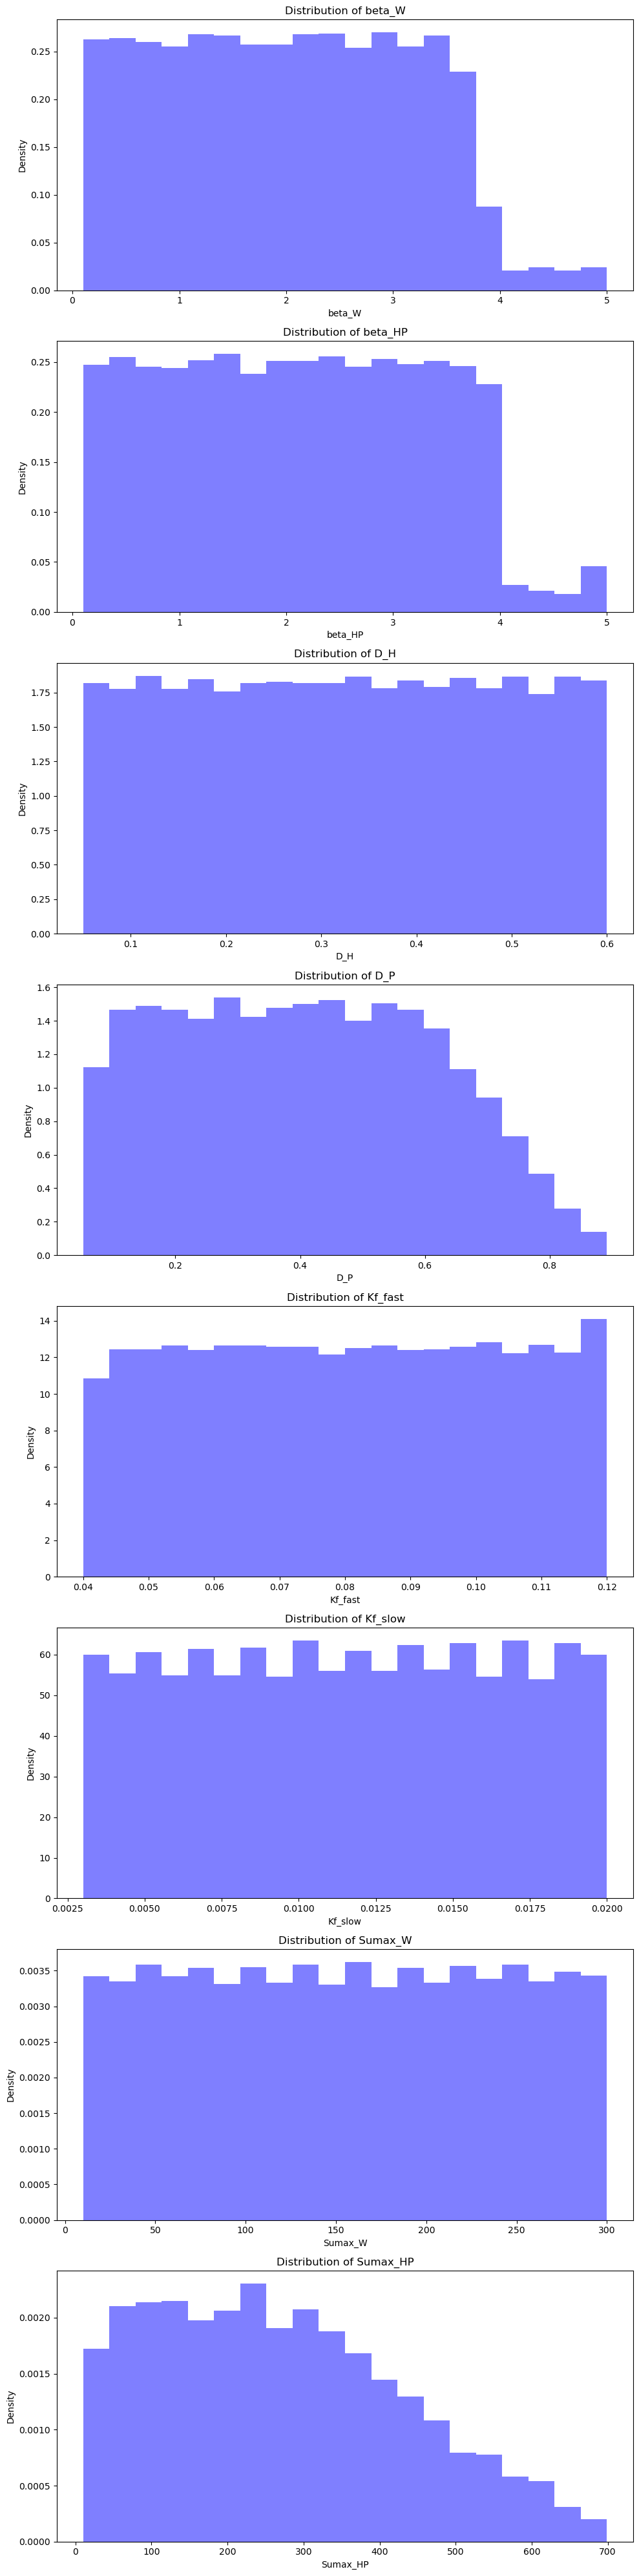

In [100]:
calculate_coefficient_of_variation(samples, parameter_names)
plot_parameter_distributions(samples, parameter_names)

# Actual sample generation

In [12]:
import pandas as pd

# Sample size
n_full = 400
n_typical = 100
# Generate custom samples

np.random.seed(827)
full_custom_samples = generate_custom_samples(full_range, n_full)
typical_custom_samples = generate_custom_samples(typical_range, n_typical)

combined_samples = full_custom_samples + typical_custom_samples
combined_samples_df =  pd.DataFrame(combined_samples)
print(combined_samples_df.tail())

     beta_W  beta_HP    D_H    D_P  Kf_fast  Kf_slow  Sumax_W  Sumax_HP
495    0.39     0.41  0.145  0.197    0.052   0.0088    103.0     120.0
496    0.31     0.33  0.119  0.157    0.058   0.0091    106.0     193.0
497    1.08     1.08  0.258  0.267    0.046   0.0075    140.0     235.0
498    1.91     1.94  0.161  0.237    0.053   0.0080    123.0     156.0
499    0.90     0.99  0.215  0.244    0.041   0.0061     72.0     167.0


Coefficient of Variation for beta_W: 0.610
Coefficient of Variation for beta_HP: 0.608
Coefficient of Variation for D_H: 0.454
Coefficient of Variation for D_P: 0.468
Coefficient of Variation for Kf_fast: 0.411
Coefficient of Variation for Kf_slow: 0.438
Coefficient of Variation for Sumax_W: 0.580
Coefficient of Variation for Sumax_HP: 0.618


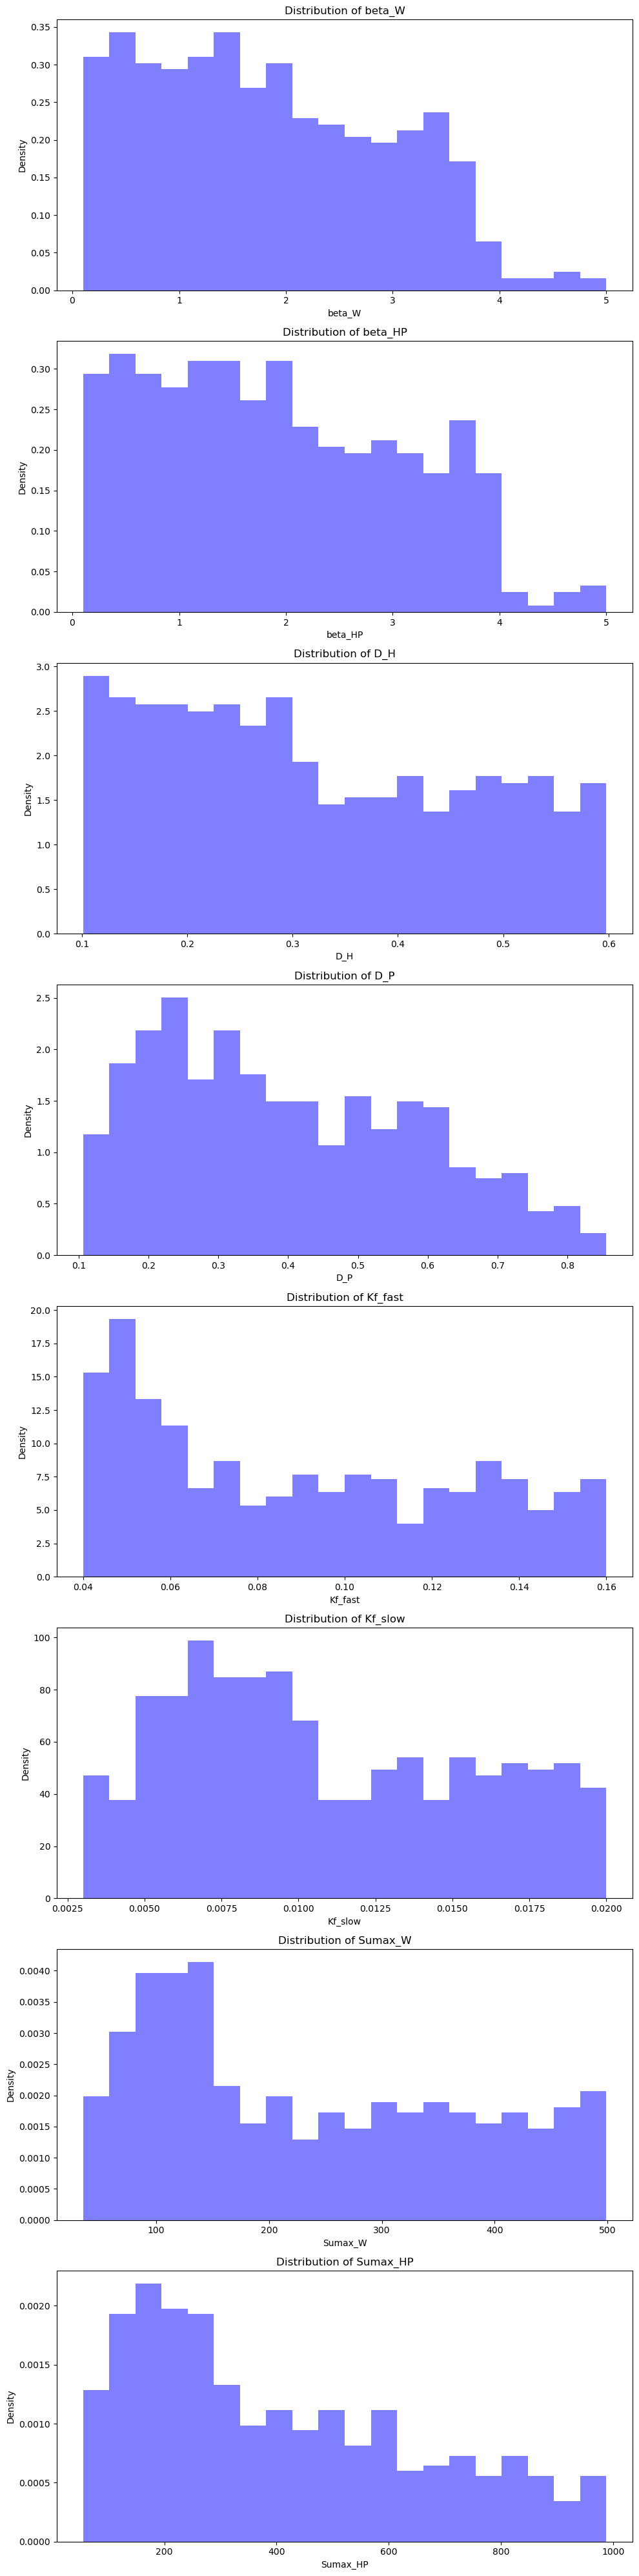

In [13]:
calculate_coefficient_of_variation(combined_samples, parameter_names)
plot_parameter_distributions(combined_samples, parameter_names)

# save the final outputs

In [14]:
# fulton ks_values = [0.0004, 0.001, 0.013]
# san diego ks_values = [0.0004, 0.0006, 0.007]
#ks_values = [0.0004, 0.001, 0.013]
ks_values = [0.0002, 0.0004]
df = pd.DataFrame(combined_samples)

# Create an empty dataframe to hold the new rows
expanded_df = pd.DataFrame()

# Repeat each row of the original dataframe three times with different 'Ks' values
for ks in ks_values:
    temp_df = df.copy()
    temp_df['Ks'] = ks
    expanded_df = pd.concat([expanded_df, temp_df], ignore_index=True)

print(expanded_df.tail())

     beta_W  beta_HP    D_H    D_P  Kf_fast  Kf_slow  Sumax_W  Sumax_HP  \
995    0.39     0.41  0.145  0.197    0.052   0.0088    103.0     120.0   
996    0.31     0.33  0.119  0.157    0.058   0.0091    106.0     193.0   
997    1.08     1.08  0.258  0.267    0.046   0.0075    140.0     235.0   
998    1.91     1.94  0.161  0.237    0.053   0.0080    123.0     156.0   
999    0.90     0.99  0.215  0.244    0.041   0.0061     72.0     167.0   

         Ks  
995  0.0004  
996  0.0004  
997  0.0004  
998  0.0004  
999  0.0004  


In [18]:
os.chdir(os.path.join("D:\\", "wflow_models"))

expanded_df.to_csv('combined_samples_v4_KsLow.csv', index=False)

In [115]:
import os
import pandas as pd

#os.chdir('/mnt/c/Workspace/Ch3/wflow_models/')
os.chdir(os.path.join("D:\\", "wflow_models"))

# Convert the list of dictionaries into a DataFrame
#df = pd.DataFrame(combined_samples)

#print(df)
# Save the DataFrame to a CSV file
df.to_csv('combined_samples_v4_Ks.csv', index=False)

# Define some functions for evaluation

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_distributions(samples, parameter_names):
    """
    Plots the distribution of each parameter using histograms.

    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to plot.
    """
    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 5 * num_params))
    
    if num_params == 1:
        axes = [axes]  # Make it iterable
    
    for ax, param in zip(axes, parameter_names):
        param_values = [sample[param] for sample in samples]
        ax.hist(param_values, bins=20, alpha=0.5, color='blue', density=True) #density = True?
        ax.set_title(f'Distribution of {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

In [10]:
def calculate_coefficient_of_variation(samples, parameter_names):
    """
    Calculates and prints the Coefficient of Variation (CV) for each parameter.
    
    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to calculate CV for.
    """
    for param in parameter_names:
        param_values = np.array([sample[param] for sample in samples])
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        cv = std_dev / mean if mean else 0  # Avoid division by zero
        print(f'Coefficient of Variation for {param}: {cv:.3f}')

# OLD

In [ ]:
import numpy as np

def sample_parameters(defaults, range_constraints):
    params = {}
    for param, stats in defaults.items():
        mean, std = stats['mean'], stats['std']
        min_val, max_val = range_constraints[param]['min'], range_constraints[param]['max']
        
        # Sample within the specified range
        while True:
            sample = np.random.normal(mean, std)
            if min_val <= sample <= max_val:
                params[param] = sample
                break
    
    # Ensure relationships between parameters
    # This may need several iterations for all conditions to be satisfied
    satisfied = False
    while not satisfied:
        if params['beta_W'] > params['beta_HP']:
            params['beta_W'], params['beta_HP'] = np.random.normal(defaults['beta_W']['mean'], defaults['beta_W']['std']), np.random.normal(defaults['beta_HP']['mean'], defaults['beta_HP']['std'])
        
        if params['D_H'] >= params['D_P']:
            params['D_H'], params['D_P'] = np.random.normal(defaults['D_H']['mean'], defaults['D_H']['std']), np.random.normal(defaults['D_P']['mean'], defaults['D_P']['std'])
        
        if params['Kf_fast'] >= params['Kf_slow']:
            params['Kf_fast'], params['Kf_slow'] = np.random.normal(defaults['Kf_fast']['mean'], defaults['Kf_fast']['std']), np.random.normal(defaults['Kf_slow']['mean'], defaults['Kf_slow']['std'])
        
        if params['Sumax_W'] > params['Sumax_HP']:
            params['Sumax_W'], params['Sumax_HP'] = np.random.normal(defaults['Sumax_W']['mean'], defaults['Sumax_W']['std']), np.random.normal(defaults['Sumax_HP']['mean'], defaults['Sumax_HP']['std'])
        
        # Check if all relationships are satisfied
        satisfied = (params['beta_W'] <= params['beta_HP'] and
                     params['D_H'] < params['D_P'] and
                     params['Kf_fast'] < params['Kf_slow'] and
                     params['Sumax_W'] <= params['Sumax_HP'])
    
    return params

# Example usage
defaults = {
    'beta_W': {'mean': 0.27, 'std': 0.135},
    'beta_HP': {'mean': 0.27, 'std': 0.135},
    'D_H': {'mean': 0.24, 'std': 0.12},
    'D_P': {'mean': 0.24, 'std': 0.12},
    'Kf_fast': {'mean': 0.04, 'std': 0.02},
    'Kf_slow': {'mean': 0.005, 'std': 0.0025},
    'Sumax_W': {'mean': 100, 'std': 50},
    'Sumax_HP': {'mean': 250, 'std': 125}
}

range_constraints = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 1},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

sample


2336410


/tmp/ipykernel_15557/1625775067.py:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
/tmp/ipykernel_15557/1625775067.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)


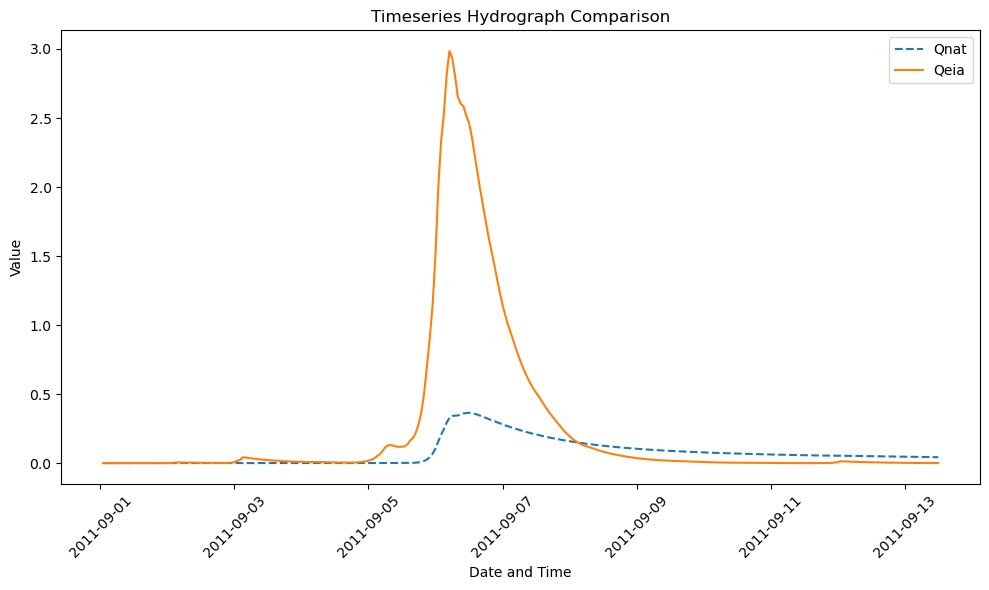

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


runId = "output/test_dt_Simp2"

outlet = str(int(wsName.split("_")[-1]))
print(outlet)

output_directory = str("../wflow_models/" +wsName + "/" + runId)

# Create a time series index
date_range = pd.date_range(start=datetimestart, periods=lastTimeStep + 1, freq=f'{timestepsecs}s')
date_range = date_range[:-1]

# Paths to the CSV files
#path0 = str(output_directory + '/Prec.csv')
path1 = str(output_directory + '/Qt.csv')
path2 = str(output_directory + '/Qeia.csv')



# Read the last column from both CSV files
df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)
#df3 = pd.read_csv(path3, usecols=['1401'], squeeze=True)
#df4 = pd.read_csv(path4, usecols=['1401'], squeeze=True)
#df5 = pd.read_csv(path5, usecols=['1401'], squeeze=True)
#df6 = pd.read_csv(path6, usecols=['1401'], squeeze=True)


# Assign the date_range as the index directly
df1.index = date_range
df2.index = date_range
#df3.index = date_range
#df4.index = date_range
#df5.index = date_range
#df6.index = date_range


# Ensure the lengths match, trimming if necessary (optional, remove if not needed)
df1 = df1.iloc[:len(date_range)]
df2 = df2.iloc[:len(date_range)]
#df3 = df3.iloc[:len(date_range)]
#df4 = df4.iloc[:len(date_range)]
#df5 = df5.iloc[:len(date_range)]
#df6 = df6.iloc[:len(date_range)]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1, label='Qnat', linestyle='--')
plt.plot(df2.index, df2, label='Qeia')
#plt.plot(df3.index, df3, label='BetaKf0Lumped', linestyle='--')
#plt.plot(df4.index, df4, label='Realistic', linestyle='--')
#plt.plot(df5.index, df5, label='None', linestyle='-.')
#plt.plot(df6.index, df6, label='BetaKf0Distributed', linestyle='-.')
plt.title('Timeseries Hydrograph Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from pyDOE import lhs

# Define the number of samples
num_samples = 1000

# LHS sampling from a uniform distribution [0, 1) for each parameter (4 parameters in total)
uniform_samples = lhs(4, samples=num_samples)

# Default values and standard deviations for Gaussian transformation
defaults = {
    'beta': {'mean': 2.55, 'std': 1.275},  # Adjust mean and std according to your needs
    'D': {'mean': 0.5, 'std': 0.25},
    'Kf': {'mean': 0.0204, 'std': 0.01},
    'Sumax': {'mean': 350, 'std': 125},
}

# Parameter constraints (example values, adjust as needed)
constraints = {
    'beta_a': {'min': 0.1, 'max': 5},
    'D_b': {'min': 0, 'max': 1},
    'Kf_c': {'min': 0.0008, 'max': 0.04},
    'Sumax_d': {'min': 100, 'max': 600},
}

# Transform uniform LHS samples to Gaussian based on default values
gaussian_samples = np.zeros(uniform_samples.shape)
for i, (key, value) in enumerate(defaults.items()):
    gaussian_samples[:, i] = norm.ppf(uniform_samples[:, i], loc=value['mean'], scale=value['std'])

# Apply constraints (simple example, more complex logic might be required for your specific model)
# Ensure samples are within defined ranges
for i, (key, constraint) in enumerate(constraints.items()):
    gaussian_samples[:, i] = np.clip(gaussian_samples[:, i], constraint['min'], constraint['max'])

# For correlated parameters, like beta, enforce a = d < b = c through sorting or other logic
# This step is highly specific to your model's constraints and might need customization

# Example: Sorting the 'beta' and 'D' samples to enforce a simple constraint
# This is a placeholder step; replace with your specific constraints logic
gaussian_samples[:, [0, 1]] = np.sort(gaussian_samples[:, [0, 1]], axis=1)

# Output
print("Sample of transformed and constrained Gaussian LHS samples for each parameter:")
for i, param in enumerate(defaults.keys()):
    print(f"{param}: {gaussian_samples[:5, i]}")
